In [13]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch

import torchvision
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 64
#image_size = (32, 32, 3)

train_set = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_pretrained_model/modified/TRAIN/', transform=transform)
test_set = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_pretrained_model/modified/TEST/', transform=transform)

#train_set = train_ds
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

#test_set = test_ds
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [15]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=16):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.1),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3),
           
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1000, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [16]:
net = AlexNet()
net.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU(i

In [5]:
criterion = nn.CrossEntropyLoss()

# also the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

lrs = []
steps = []

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in tqdm(range(0, 100)):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    if epoch % 10 == 0:
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the test set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the test set
    with T.no_grad():
        correct = 0
        total = 0
        test_running_loss = .0
        for data in test_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if epoch == 99:
                # Append batch prediction results
                predlist=torch.cat([predlist,predicted.view(-1).cpu()])
                lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

        test_running_loss /= len(test_loader)
        test_loss.append(test_running_loss)
        test_running_acc = correct / total
        test_acc.append(test_running_acc)
        
        if epoch % 10 == 0:
            print('Test Acc.  => {:.3f}%'.format(100 * test_running_acc), end=' | ')
            print('Test Loss  => {:.5f}'.format(test_running_loss))

print('Finished Training')

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 0
Train Acc. => 15.437% | Train Loss => 2.68617
Test Acc.  => 16.163% | Test Loss  => 2.64315

Epoch: 10
Train Acc. => 43.939% | Train Loss => 1.59369
Test Acc.  => 41.563% | Test Loss  => 1.61022

Epoch: 20
Train Acc. => 54.492% | Train Loss => 1.28506
Test Acc.  => 49.911% | Test Loss  => 1.34762

Epoch: 30
Train Acc. => 71.401% | Train Loss => 0.80312
Test Acc.  => 64.654% | Test Loss  => 0.97992

Epoch: 40
Train Acc. => 80.326% | Train Loss => 0.53207
Test Acc.  => 76.732% | Test Loss  => 0.70245

Epoch: 50
Train Acc. => 86.132% | Train Loss => 0.37058
Test Acc.  => 77.975% | Test Loss  => 0.55421

Epoch: 60
Train Acc. => 89.133% | Train Loss => 0.28368
Test Acc.  => 80.462% | Test Loss  => 0.54646

Epoch: 70
Train Acc. => 91.350% | Train Loss => 0.23559
Test Acc.  => 80.995% | Test Loss  => 0.50049

Epoch: 80
Train Acc. => 92.723% | Train Loss => 0.18657
Test Acc.  => 80.107% | Test Loss  => 0.48332

Epoch: 90
Train Acc. => 93.900% | Train Loss => 0.15199
Test Acc.  => 82.

## Visualization

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

[[91  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  6  0  0  0  0  0  0  1  3  0  0  0  0]
 [ 0  0 42  1  1  0  3  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  4  0  1  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  1  0 36  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  2  0  0  0 38  0  1  0  0  0  0  0  0  0  0]
 [ 1  0  2  0  1  1 22  0  0  0  0  0  0  0  1  0]
 [ 2  0  0  0  0  0  0 29  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 51  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0 16  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  1  0 29  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 36  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  3 16  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 16 22]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  8]]


<AxesSubplot:>

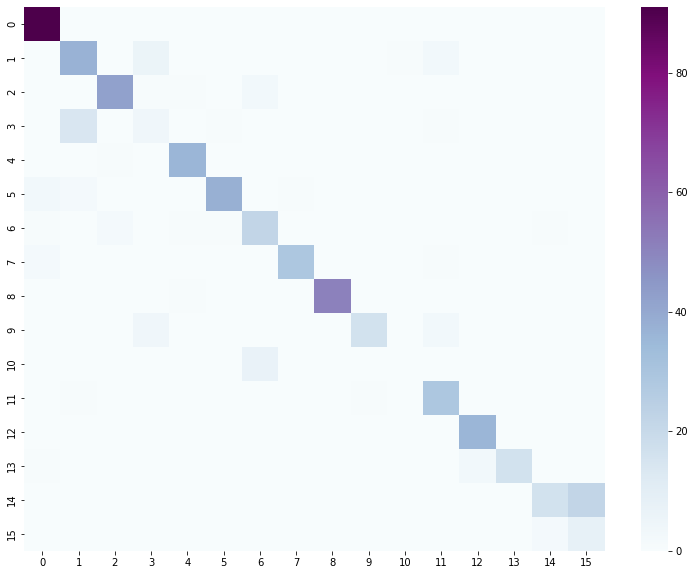

In [9]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(conf_mat, annot=False, ax=ax, cmap="BuPu")

In [10]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[100.          78.72340426  89.36170213  20.          97.2972973
  86.36363636  78.57142857  90.625       98.07692308  69.56521739
   0.          93.5483871  100.          80.          42.10526316
  80.        ]


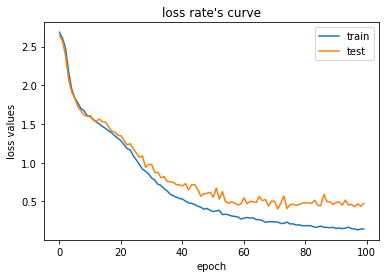

In [11]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.xlabel("epoch")
plt.ylabel("loss values")
plt.title("loss rate's curve")
plt.legend()
plt.show()

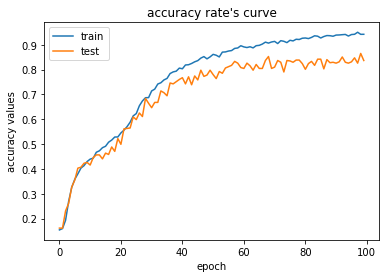

In [12]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.xlabel("epoch")
plt.ylabel("accuracy values")
plt.title("accuracy rate's curve")
plt.legend()
plt.show()

In [13]:
#torch.save(net.state_dict(), "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train/dict_Lin_network_2nd-try")

In [14]:
#torch.save(net, "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train/Lin_network_entire_model_2nd-try")